We are going to visualize the training with the data augmentations that were used in the training

In [1]:
# -*- coding: utf-8 -*-
# IMPORTS

# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)

# additional packages
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import argparse
import os
import time
import glob
from tqdm import tqdm
import sys
USER = os.getenv('USER')
sys.path.append(f'/home/{USER}/CODE/Pytorch-fingerprints/')

# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, train_for_epoch, save_config, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_tanimoto

from utils.models import resnet_10_chan, effnet_10_chan, eff_net_bias_warmer

from utils.dataloader import  QUAM_with_noise, dataset_ks_dict, parse_k1_to_k, parse_val_ks

print('Packages loaded')

# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.device(0)
print(device, torch.cuda.get_device_name(0))


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = '300k_1024_all_ks_dropout_0_5'
        self.n_fp = 1024  # number of fingerprints
        self.ratio = 0.95  # train/test ratio
        self.seed = 42
        self.virtual_epochs = 10 # number of times we save the model per epoch. If equal to 1
                                # we only save at the end of each epoch.
        self.tqdm_flag = True

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 50  # Test batch size
        self.epochs = 100  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.7  # prob of applying zoom
        self.max_zoom = 0.7  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

        # Gaussian noise
        self.gauss_noise = 2 # std of gaussian noise

        # comments
        self.comments = 'It uses all K folders'

        # METRICS AND MODELS PATHS
        self.exp_path = os.path.join('./experiments', self.experiment_name)
        self.metrics_path = os.path.join(self.exp_path, 'metrics')
        self.models_path = os.path.join(self.exp_path, 'models')



## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)
# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

# Load data
data_path = F'/home/{USER}/QUAM-AFM/datasets/285k_train_15k_val_test_1024bits_df.gz'
dataset_df = pd.read_pickle(data_path)

train_df = dataset_df[dataset_df['split'] == 'train']
val_df = dataset_df[dataset_df['split'] == 'val']

train_dict = dataset_ks_dict(train_df, parse_k1_to_k)

print('training dict created')

train_k_df = pd.concat(train_dict.values(), ignore_index=True)
val_k_df = parse_val_ks(val_df)

trainset = QUAM_with_noise(args, train_k_df, mode='train')
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=8,
                                           pin_memory=True)


PyTorch version: 1.12.1
Packages loaded
available devices: 1
cuda:0 NVIDIA A40
Experiment name: 300k_1024_all_ks_dropout_0_5
training dict created


/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [2]:
batch, _ = next(iter(train_loader))

In [3]:
batch.size()

torch.Size([50, 10, 224, 224])

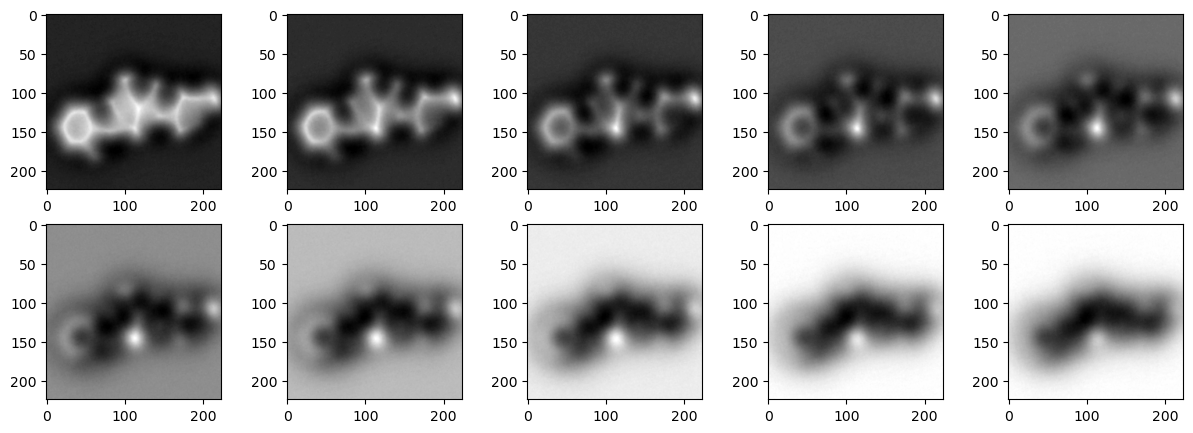

In [10]:
index = 32
train_img = batch[index]
#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(train_img[0], cmap = 'gray')
axarr[0,1].imshow(train_img[1], cmap = 'gray')
axarr[0,2].imshow(train_img[2], cmap = 'gray')
axarr[0,3].imshow(train_img[3], cmap = 'gray')
axarr[0,4].imshow(train_img[4], cmap = 'gray')
axarr[1,0].imshow(train_img[5], cmap = 'gray')
axarr[1,1].imshow(train_img[6], cmap = 'gray')
axarr[1,2].imshow(train_img[7], cmap = 'gray')
axarr[1,3].imshow(train_img[8], cmap = 'gray')
axarr[1,4].imshow(train_img[9], cmap = 'gray')